In [1]:
import sys
print("%x" % sys.maxsize, sys.maxsize > 2**32)

7fffffffffffffff True


## BWTEK spectro sandbox

In [45]:
ct.windll.kernel32.GetTickCount64()

89444577

In [2]:
import ctypes as ct
from time import sleep
from datetime import datetime
lib = ct.cdll.LoadLibrary("./bwtek/BWTEKUSB.dll")
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


D:\winpython3.7\WPy64-37120\pypy3.7-v7.3.7-win64\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
lib.InitDevices.restype = ct.c_bool
lib.InitDevices()

True

In [4]:
lib.GetDeviceCount()

1

In [5]:
# get channels
nChannelStatus=(ct.c_ubyte*32)()
print(lib.bwtekSetupChannel( -1,ct.byref(nChannelStatus)))
bs = bytearray(nChannelStatus)
bs

1


bytearray(b'\x00\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7\xc7')

In [5]:
nUSBType = ct.c_int(1)
lib.GetUSBType(ct.byref(nUSBType),0)
nUSBType.value

2

In [31]:
# read eprom
filename = ct.create_string_buffer(b"para.txt")
r=lib.bwtekReadEEPROMUSB(filename,0)
r,filename.value

(1, b'para.txt')

In [40]:
# Get spectrometer parameters
nTiming = ct.c_int(1)
nPixelNo = ct.c_int(2048)
nInputMode = ct.c_int(1)
lib.bwtekTestUSB(nTiming,nPixelNo,nInputMode,0,None)

1

In [164]:
#read analog voltage
dVoltage = ct.c_double()
nValue= ct.c_int32()
lib.bwtekGetAnalogIn(0,ct.byref(nValue), ct.byref(dVoltage),0)
dVoltage,nValue

(c_double(1.8756103515625), c_long(3073))

In [16]:
# read temperature
nADValue=ct.c_int32()
nTemperature = ct.c_double()
lib.bwtekReadTemperature(0x11,ct.byref(nADValue), ct.byref(nTemperature), 0)
nTemperature,nADValue

(c_double(200.0), c_long(4095))

In [306]:
import psutil, os
p = psutil.Process(os.getpid())
p.nice(psutil.HIGH_PRIORITY_CLASS)


In [307]:
p.nice()

<Priority.HIGH_PRIORITY_CLASS: 128>

In [ ]:
# set Integration time
lTime=ct.c_long(5)
lib.bwtekSetTimeUSB( lTime, 0)
lTime

In [396]:
nTriggerMode=ct.c_int()
pArray=(ct.c_ushort*2048)()

p.nice(psutil.REALTIME_PRIORITY_CLASS)

# read datas
n=500
delay=0.00

sleep(1)
res=np.zeros((2048,n))
volts=np.zeros(n)
ttlin=np.zeros(n)
tstamps=np.zeros(n,dtype='datetime64[us]')
tstamps0=np.zeros(n,dtype='datetime64[us]')
for i in range(n):
    tstamps0[i]=np.datetime64(datetime.datetime.now())
    volts[i]=lib.bwtekGetExtStatus(0)
    lib.bwtekDataReadUSB(0,ct.byref(pArray), 0)
    #lib.bwtekGetAnalogIn(0,ct.byref(nValue), ct.byref(dVoltage),0)
    res[:,i]=np.ctypeslib.as_array(pArray)
    ttlin[i]=lib.bwtekGetExtStatus(0)
    tstamps[i]= np.datetime64(datetime.datetime.now())
    #sleep(delay)
p.nice(psutil.NORMAL_PRIORITY_CLASS)    


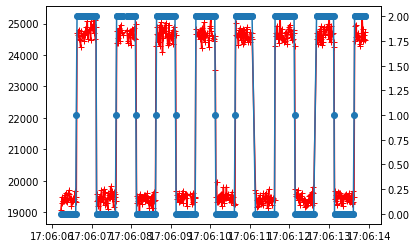

In [397]:
plot(tstamps,res[840,:],'r-+')
plt.twinx()
plot(tstamps,ttlin+volts,'-o')

(5125.477326614956, numpy.timedelta64(14299,'us'), 14299.434)

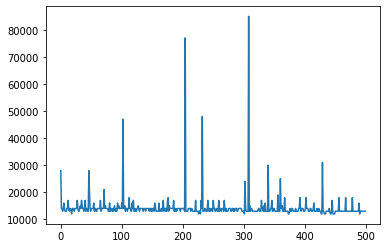

In [398]:
delta=tstamps-tstamps0
plot(delta)
np.std(delta.astype(int)),np.mean(delta),np.mean(delta.astype(int))

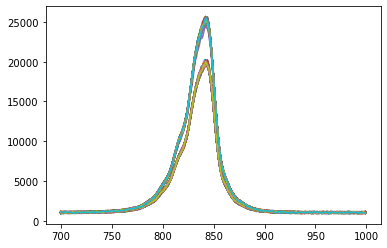

In [399]:
plot(np.arange(700,1000),res[700:1000,:]);

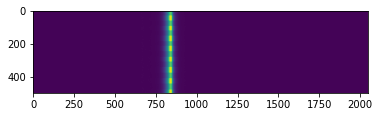

In [400]:
imshow(res[::1,:].transpose())

In [401]:
#trow away edge samples
low=np.where(ttlin+volts==0)[0]
high=np.where(ttlin+volts==2)[0]
size(low),size(high)

(254, 236)

In [402]:
diff_spectra=-np.mean(res[:,low],axis=1)+np.mean(res[:,high],axis=1)

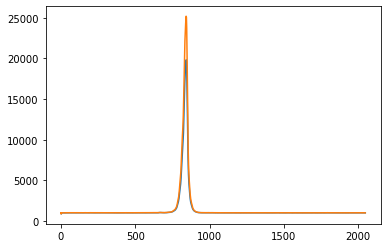

In [403]:
plot(np.mean(res[:,low],axis=1))
plot(np.mean(res[:,high],axis=1))

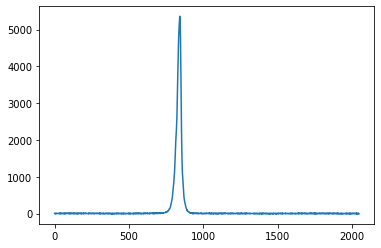

In [404]:
plot(diff_spectra)

In [52]:
lib.CloseDevices()

1